# Проект по бинарной классификации рисков сердечного приступа

## Обзор и цели

Этот проект посвящён разработке модели бинарной классификации, предсказывающей высокий или низкий риск сердечного приступа по реальным медицинским данным. Цель — провести исследовательский анализ данных (EDA), построить точную и интерпретируемую модель, а затем развернуть её как приложение FastAPI для получения предсказаний на новых данных.

Датасет включает ключевые группы признаков:
- Антропометрия: возраст, индекс массы тела (ИМТ).
- Образ жизни: курение, употребление алкоголя, физическая активность, диета.
- Клинические измерения: артериальное давление, частота сердечных сокращений.
- Лабораторные показатели: холестерин, триглицериды, уровень глюкозы.
- Сердечные биомаркеры: тропонин, CK-MB.
- Медицинский анамнез: диабет, семейная история сердечных заболеваний, прошлые сердечные события, приём лекарств и др.

Проект состоит из двух частей:
1. Анализ данных и построение модели классификации.
2. Развёртывание сервиса на FastAPI для онлайновых предсказаний риска.


## Ключевые задачи

1. **EDA (разведочный анализ):** изучить распределения признаков, выявить аномалии, пропуски и возможные утечки.
2. **Предобработка данных:** обработать пропуски, закодировать категориальные признаки, удалить/трансформировать вводящие в заблуждение признаки.
3. **Инженерия признаков:** использовать доменные знания (например, расчёт риск-скоров, агрегирование факторов риска) для улучшения качества модели.
4. **Моделирование:** обучить и сравнить несколько моделей классификации; акцент на ансамблях (**Random Forest**, **XGBoost**, **CatBoost**), избегая чрезмерно простых подходов.
5. **Метрики и валидация:** выбрать метрики с учётом дисбаланса классов и клинической значимости (например, ROC-AUC, PR-AUC, recall, F2), обосновать выбор.
6. **Интерпретируемость:** применить **SHAP** для выявления ключевых факторов и проверки согласованности поведения модели с медицинскими знаниями.
7. **Продакшн (FastAPI):** разработать сервис, принимающий вход (CSV/JSON) и возвращающий уровни риска в формате JSON.
8. **Документация и код:** подготовить воспроизводимый, структурированный код (ООП-подход), ноутбук с анализом, артефакты предсказаний и инструкцию по использованию.


# EDA

Краткий план EDA:
- Загрузить датасет и изучить структуру (размер, типы, описание признаков).
- Оценить качество данных: пропуски, дубликаты, выбросы, возможные утечки.
- Посчитать базовые статистики и проверить распределения признаков.
- Исследовать баланс целевого класса.
- Проанализировать корреляции и мультиколлинеарность (heatmap, парные графики).
- Изучить связи признаков с целевой переменной (box/violin, KDE, bar).
- Зафиксировать первичные инсайты и гипотезы для последующей предобработки и моделирования.


In [175]:
# Библиотеки
from __future__ import annotations
import os
import re
import json
import warnings
from typing import Optional, List, Tuple, Dict


import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_auc_score
from IPython.display import display, Markdown

warnings.filterwarnings("ignore")

In [176]:
# Просмотрим датасеты

# Пути к датасетам
data_dir = Path("..") / "data"
train_path = next(data_dir.glob("*heart_train*.csv"))
test_path  = next(data_dir.glob("*heart_test*.csv"))

# Загружаем датасеты
df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

# Быстрый просмотр для обоих
print("\n=== TRAIN DATASET ===")
print(df_train.head().T)
print(df_train.describe())
train_scan = QuickDatasetScan(
    df_train,
    name="heart_train",
    quasi_const_threshold=0.99,
    percentiles=(1, 5, 25, 50, 75, 95, 99),
    check_suspicious_index=True,
    verbose=True
)
train_results = train_scan.scan(top_missing=20, top_memory=20)

print("\n=== TEST DATASET ===")
print(df_test.head().T)
print(df_test.describe())
test_scan = QuickDatasetScan(
    df_test,
    name="heart_test",
    quasi_const_threshold=0.99,
    percentiles=(1, 5, 25, 50, 75, 95, 99),
    check_suspicious_index=True,
    verbose=True
)
test_results = test_scan.scan(top_missing=20, top_memory=20)


=== TRAIN DATASET ===
                                        0         1         2         3  \
Unnamed: 0                              0         1         2         3   
Age                              0.359551  0.202247  0.606742  0.730337   
Cholesterol                      0.732143     0.325  0.860714  0.007143   
Heart rate                       0.074244  0.047663  0.055912  0.053162   
Diabetes                              1.0       1.0       1.0       0.0   
Family History                        1.0       1.0       0.0       0.0   
Smoking                               1.0       0.0       1.0       1.0   
Obesity                               1.0       0.0       1.0       0.0   
Alcohol Consumption                   1.0       1.0       1.0       1.0   
Exercise Hours Per Week          0.535505   0.06869  0.944001  0.697023   
Diet                                    1         2         2         0   
Previous Heart Problems               1.0       1.0       1.0       0.0   
Me

## Краткий предварительный обзор данных

### Train dataset
- **Размер:** 8685 строк × 28 столбцов
- **Память:** 2.23 MB, дубликатов: 0
- **Пропуски:** 2187 (0.90%), локализованы в 9 признаках (~2.8% строк)
- **Подозрительный столбец:** `Unnamed: 0` (индексоподобный)
- **Типы данных:** 26 числовых, 1 категориальный (`Gender`), 1 ID
- **Особенности:**
  - Есть бинарные и категориальные признаки, закодированные числами (0/1, 0/1/2)
  - Несколько признаков с фиксированными значениями у большинства наблюдений (потенциальные квазиконстанты)
  - `CK-MB`, `Troponin` имеют малую дисперсию
  - Все численные признаки отмасштабированы (0–1 или нормализованные диапазоны)

### Test dataset
- **Размер:** 966 строк × 27 столбцов
- **Память:** 0.24 MB, дубликатов: 0
- **Пропуски:** 279 (1.07%), локализованы в тех же признаках, что и в train
- **Подозрительный столбец:** `Unnamed: 0` (индексоподобный)
- **Типы данных:** 25 числовых, 1 категориальный (`Gender`), 1 ID
- **Особенности:** структура и распределения близки к train

### Рекомендации для EDA
1. Удалить `Unnamed: 0` как лишний индекс, цифры по порядку, простая нумерация.
2. Проверить квазиконстантные признаки `CK-MB`, `Troponin` — возможен дроп как утечку, в клинике это диагностические маркеры текущего повреждения миокарда.
3. Проверить `Previous Heart Problems`, `Medication Use` — возможен дроп как прокси утечку. Наличие перенесённых событий и приём кардиопрепаратов часто являются критерием отнесения к группе высокого риска.
3. Для категориальных кодов (0/1/2) уточнить смысл и обработать как категориальные фичи.
4. Обратить внимание на пропуски в 9 признаках — решить стратегию заполнения или удаления.
5. Подтвердить масштабирование — возможно, не требуется повторного нормирования.


In [177]:
# класс для EDA
# medical_eda.py

class MedicalEDA:
    """
    EDA-помощник для бинарной мед. классификации (train/test).
    Никаких файлов и автосохранений — только расчёты, проверки и графики.
    """

    def __init__(
        self,
        train_path: str,
        test_path: Optional[str] = None,
        target_col: Optional[str] = None,
        id_candidates: Tuple[str, ...] = ("id", "ID", "Id", "patient_id", "record_id"),
        random_state: int = 42,
        # Авто-дроп индексоподобных столбцов с подозрительными именами ("Unnamed: 0" и т.п.)
        drop_unnamed_index: bool = True,
        # Печатать информативные сообщения
        verbose: bool = True,
        # До какого размера матрицы корреляций подписывать числа в ячейках
        corr_annotate_max: int = 30,
        # Доменно подозрительные имена как потенциальные утечки
        leakage_name_suspects: Tuple[str, ...] = ("Previous Heart Problems", "Medication Use"),
        # Порог single-feature ROC-AUC, выше которого фича помечается как утечка/прокси
        leakage_auc_threshold: float = 0.85,
        # Порог «почти-совпадения» бинарной фичи с таргетом (accuracy)
        leakage_almost_equal_acc: float = 0.97,
    ):
        self.train_path = train_path
        self.test_path = test_path
        self._target = target_col
        self.id_candidates = id_candidates
        self.random_state = random_state

        self.drop_unnamed_index = drop_unnamed_index
        self.verbose = verbose
        self.corr_annotate_max = int(corr_annotate_max)
        self.leakage_name_suspects = tuple(leakage_name_suspects)
        self.leakage_auc_threshold = float(leakage_auc_threshold)
        self.leakage_almost_equal_acc = float(leakage_almost_equal_acc)

        # Данные
        self.train: Optional[pd.DataFrame] = None
        self.test: Optional[pd.DataFrame] = None

        # Распознанные сущности
        self.id_col: Optional[str] = None
        self.feature_types: Dict[str, str] = {}  # {col: "numeric"|"categorical"|"binary"}
        self.numeric_cols: List[str] = []
        self.categorical_cols: List[str] = []
        self.binary_cols: List[str] = []

        # Результаты EDA
        self._missing_train: Optional[pd.DataFrame] = None
        self._missing_test: Optional[pd.DataFrame] = None
        self._class_dist: Optional[pd.Series] = None
        self._desc_numeric: Optional[pd.DataFrame] = None
        self._high_corr_pairs: Optional[pd.DataFrame] = None
        self._vif_df: Optional[pd.DataFrame] = None
        self._drift_df: Optional[pd.DataFrame] = None
        self._leakage_df: Optional[pd.DataFrame] = None
        self._corr_matrix: Optional[pd.DataFrame] = None
        self._spikes_df: Optional[pd.DataFrame] = None
        self._spikes_summary_df: Optional[pd.DataFrame] = None

        # Служебное: что дропнули как «индексоподобное»
        self._dropped_index_like: List[str] = []

    # ------------------------ Свойства для доступа к итогам ------------------------ #
    @property
    def target_col(self) -> Optional[str]:
        """Имя колонки таргета, если найден/задан."""
        return self._target

    @property
    def missing_train(self) -> Optional[pd.DataFrame]:
        """Таблица пропусков по train (доля/кол-во)."""
        return self._missing_train

    @property
    def missing_test(self) -> Optional[pd.DataFrame]:
        """Таблица пропусков по test (доля/кол-во)."""
        return self._missing_test

    @property
    def class_distribution(self) -> Optional[pd.Series]:
        """Распределение классов по таргету (train)."""
        return self._class_dist

    @property
    def numeric_description(self) -> Optional[pd.DataFrame]:
        """Базовая статистика по числовым признакам (mean/std/... + skew/kurtosis)."""
        return self._desc_numeric

    @property
    def corr_matrix(self) -> Optional[pd.DataFrame]:
        """Матрица абсолютных корреляций по числовым признакам."""
        return self._corr_matrix

    @property
    def high_corr_pairs(self) -> Optional[pd.DataFrame]:
        """Пары числовых признаков с |r| ≥ порога."""
        return self._high_corr_pairs

    @property
    def vif_table(self) -> Optional[pd.DataFrame]:
        """Таблица VIF по подмножеству числовых признаков."""
        return self._vif_df

    @property
    def drift_table(self) -> Optional[pd.DataFrame]:
        """Результаты проверки дрейфа train vs test."""
        return self._drift_df

    @property
    def leakage_table(self) -> Optional[pd.DataFrame]:
        """Таблица потенциальных утечек/прокси-фич."""
        return self._leakage_df

    @property
    def dropped_index_like(self) -> List[str]:
        """Имена столбцов, удалённых как «индексоподобные»."""
        return list(self._dropped_index_like)

    @property
    def spikes_table(self):
        # Обычный DataFrame с русскими колонками
        if not hasattr(self, "_spikes_df") or self._spikes_df.empty:
            return pd.DataFrame()

        df = self._spikes_df.copy()
        rename_map = {
            "feature": "Признак",
            "spike_value": "Значение пика",
            "share": "Доля",
            "n": "Количество",
            "method": "Метод",
            "comment": "Комментарий",
            "maybe_imputed": "Возможна импутация"
        }
        df.rename(columns=rename_map, inplace=True)
        return df

    def styled_spikes_table(self):
        # Красивый вывод
        if not hasattr(self, "_spikes_df") or self._spikes_df.empty:
            return pd.DataFrame()

        df = self.spikes_table.copy()
        df["Доля"] = pd.to_numeric(df["Доля"], errors="coerce", downcast="float",)
        return (
            df.style
            .format({"Доля": "{:.1%}"})
            .background_gradient(subset=["Доля"], cmap="Reds")
            .set_properties(**{"text-align": "left"})
        )

    @property
    def spikes_summary(self) -> Optional[pd.DataFrame]:
        """Сводная таблица пиков на уровне признака (кол-во, макс/сумма долей, методы, есть ли импутации)."""
        return self._spikes_summary_df

    # ------------------------ Загрузка и базовая чистка ------------------------ #
    def _looks_suspicious_index_name(self, name: str) -> bool:
        """
        Проверяет, похоже ли имя столбца на служебный индекс:
        пустое, начинается с "Unnamed", или типичные "index/row/seq/no/num/number/№".
        """
        if name is None:
            return True
        n = str(name).strip()
        if n == "":
            return True
        if re.match(r"^Unnamed(\s*[:_]\s*\d+)?", n, flags=re.I):
            return True
        if re.fullmatch(r"(index|row|seq|№|no|num|number)", n, flags=re.I):
            return True
        return False

    def _is_contiguous_integer_index(self, s: pd.Series) -> bool:
        """
        Проверяет, что столбец — непрерывная последовательность целых без пропусков со шагом 1.
        """
        x = pd.to_numeric(s, errors="coerce")
        if x.isna().any():
            return False
        v = x.values
        if not np.all(np.isfinite(v)):
            return False
        if not np.allclose(v, np.round(v)):
            return False
        n = len(v)
        if len(np.unique(v)) != n:
            return False
        xmin, xmax = int(v.min()), int(v.max())
        return (xmax - xmin + 1) == n

    def _drop_index_like_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Полуавтомат: если столбец (а) выглядит как счётчик и (б) имя подозрительное — удаляем и логируем;
        иначе только предупреждаем.
        """
        if df is None:
            return df
        to_drop = []
        for col in df.columns:
            by_name = self._looks_suspicious_index_name(col)
            by_vals = self._is_contiguous_integer_index(df[col])
            if by_name and by_vals:
                to_drop.append(col)
                if self.verbose:
                    print(f"[INFO] Столбец «{col}» выглядит как служебный индекс — удаляю.")
            elif by_name and self.verbose:
                print(f"[WARN] Имя «{col}» подозрительное, но по значениям не индекс — оставляю.")
            elif by_vals and self.verbose:
                print(f"[WARN] «{col}» выглядит как индекс по значениям, но имя ок — оставляю.")
        if to_drop:
            self._dropped_index_like.extend(to_drop)
            df = df.drop(columns=to_drop)
        return df

    def load(self):
        """
        Загружает train/test из CSV и (если включено) убирает индексоподобные столбцы:
        правило «подозрительное имя + непрерывная целочисленная последовательность».
        """
        self.train = pd.read_csv(self.train_path)
        if self.test_path and os.path.exists(self.test_path):
            self.test = pd.read_csv(self.test_path)
        if self.drop_unnamed_index:
            self.train = self._drop_index_like_columns(self.train)
            if self.test is not None:
                self.test = self._drop_index_like_columns(self.test)

    def detect_id(self):
        """Определяет ID-колонку по списку кандидатов и regex /id/ с проверкой уникальности."""
        if self.train is None:
            raise RuntimeError("Сначала вызовите load().")
        for c in self.id_candidates:
            if c in self.train.columns:
                self.id_col = c
                return self.id_col
        for c in self.train.columns:
            if re.search(r"\bid\b", c, flags=re.I) and self.train[c].is_unique:
                self.id_col = c
                return self.id_col
        return None

    def detect_target(self) -> Optional[str]:
        """
        Автоопределение таргета:
          (1) по названию (target|label|risk|outcome|y|class) и бинарности,
          (2) по любой бинарной колонке (приоритет 0/1).
        """
        if self._target is not None and self._target in self.train.columns:
            return self._target

        candidates_by_name = [c for c in self.train.columns
                              if re.search(r"(target|label|risk|outcome|y|class)", c, flags=re.I)]
        named_bin = [c for c in candidates_by_name if self.train[c].dropna().nunique() == 2]
        if named_bin:
            self._target = named_bin[0]
            return self._target

        for c in self.train.columns:
            if c == self.id_col:
                continue
            if self.train[c].dropna().nunique() == 2:
                vals = set(pd.to_numeric(self.train[c], errors="coerce").dropna().unique())
                if vals.issubset({0, 1}) or vals.issubset({0.0, 1.0}):
                    self._target = c
                    return self._target

        for c in self.train.columns:
            if c not in (self.id_col, self._target) and self.train[c].dropna().nunique() == 2:
                self._target = c
                return self._target
        return None

    # ------------------------ Типы признаков ------------------------ #
    def infer_types(self):
        """
        Распознаёт типы признаков (numeric / categorical / binary), исключая ID и таргет.
        """
        if self.train is None:
            raise RuntimeError("Сначала вызовите load().")

        self.feature_types.clear()
        self.numeric_cols.clear()
        self.categorical_cols.clear()
        self.binary_cols.clear()

        for col in self.train.columns:
            if col in (self.id_col, self._target):
                continue
            s = self.train[col]
            if s.dtype.kind in "biufc":
                nun = s.nunique(dropna=True)
                if nun == 2:
                    self.feature_types[col] = "binary"
                    self.binary_cols.append(col)
                elif (s.dtype.kind in "iu") and (nun <= 10):
                    self.feature_types[col] = "categorical"
                    self.categorical_cols.append(col)
                else:
                    self.feature_types[col] = "numeric"
                    self.numeric_cols.append(col)
            else:
                if s.nunique(dropna=True) == 2:
                    self.feature_types[col] = "binary"
                    self.binary_cols.append(col)
                else:
                    self.feature_types[col] = "categorical"
                    self.categorical_cols.append(col)

    # ------------------------ Сводные расчёты ------------------------ #
    def missingness(self):
        """Считает пропуски (доля и количество) для train/test."""
        def miss(df: Optional[pd.DataFrame]) -> Optional[pd.DataFrame]:
            if df is None:
                return None
            m = df.isna().mean().sort_values(ascending=False)
            out = pd.DataFrame({"missing_rate": m, "n_missing": df.isna().sum()})
            out["n_rows"] = len(df)
            return out[out["missing_rate"] > 0]
        self._missing_train = miss(self.train)
        self._missing_test = miss(self.test)

    def class_balance(self):
        """Распределение классов по таргету (если найден)."""
        if self._target and self._target in self.train.columns:
            self._class_dist = self.train[self._target].value_counts(dropna=False)
        else:
            self._class_dist = None

    def describe_numeric(self):
        """Базовая статистика по числовым + асимметрия и эксцесс."""
        if self.numeric_cols:
            desc = self.train[self.numeric_cols].describe().T
            desc["skew"] = self.train[self.numeric_cols].skew()
            desc["kurtosis"] = self.train[self.numeric_cols].kurtosis()
            self._desc_numeric = desc
        else:
            self._desc_numeric = pd.DataFrame()

    def find_duplicates_constants(self) -> Tuple[List[str], List[str]]:
        """Возвращает списки (константы, квазиконстанты ≥ 99%)."""
        constants, quasiconstants = [], []
        for col in self.train.columns:
            if col == self._target:
                continue
            vc = self.train[col].value_counts(dropna=False, normalize=True)
            if len(vc) == 1:
                constants.append(col)
            elif vc.iloc[0] >= 0.99:
                quasiconstants.append(col)
        return constants, quasiconstants

    # ------------------------ Корреляции и VIF ------------------------ #
    def correlations(self, corr_threshold: float = 0.9):
        """Матрица |corr| по числовым и пары с |r| ≥ порога."""
        if not self.numeric_cols:
            self._corr_matrix = None
            self._high_corr_pairs = pd.DataFrame()
            return
        corr = self.train[self.numeric_cols].corr().abs()
        self._corr_matrix = corr

        pairs = []
        cols = corr.columns
        for i in range(len(cols)):
            for j in range(i + 1, len(cols)):
                r = corr.iloc[i, j]
                if r >= corr_threshold:
                    pairs.append((cols[i], cols[j], r))
        self._high_corr_pairs = (
            pd.DataFrame(pairs, columns=["feature_1", "feature_2", "abs_corr"])
              .sort_values("abs_corr", ascending=False)
        )

    def _compute_vif(self, X: pd.DataFrame) -> pd.DataFrame:
        """Считает VIF через линейную регрессию (sklearn) для каждого столбца как целевой."""
        from sklearn.linear_model import LinearRegression
        rows = []
        for col in X.columns:
            y = X[col].values
            X_ = X.drop(columns=[col]).values
            lr = LinearRegression()
            lr.fit(X_, y)
            r2 = lr.score(X_, y)
            vif = np.inf if r2 >= 0.999999 else (1.0 / (1.0 - r2))
            rows.append((col, vif))
        return pd.DataFrame(rows, columns=["feature", "vif"]).sort_values("vif", ascending=False)

    def vif(self, max_features: int = 30):
        """Считает VIF на подмножестве самых вариативных числовых признаков."""
        if not self.numeric_cols:
            self._vif_df = pd.DataFrame(columns=["feature", "vif"])
            return
        var = self.train[self.numeric_cols].var().sort_values(ascending=False)
        cols = list(var.index[:max_features])
        X = self.train[cols].dropna()
        X = X.loc[:, X.std() > 0]
        if X.shape[1] == 0:
            self._vif_df = pd.DataFrame(columns=["feature", "vif"])
            return
        self._vif_df = self._compute_vif(X)

    # ------------------------ Проверки утечек / прокси-фич ------------------------ #
    def leakage_checks(self, high_target_corr: float = 0.8) -> pd.DataFrame:
        """
        Эвристики утечек/прокси:
          1) подозрительные имена (risk|outcome|attack|event|target|label|diagnos|result|
             previous|history|medic|treat|therapy|surgery|stent|procedure|hospital)
          2) точный/почти точный дубликат таргета (для бинарных)
          3) высокая point-biserial корреляция (для числовых)
          4) single-feature ROC-AUC (числовые и низкокардинальные категориальные)
          5) явные подозреваемые по имени: self.leakage_name_suspects
        """
        findings = []

        if self.train is None or self._target not in self.train.columns:
            self._leakage_df = pd.DataFrame(columns=["feature", "issue", "metric"])
            return self._leakage_df

        t_raw = self.train[self._target]
        t = pd.to_numeric(t_raw, errors="coerce")
        is_bin_target = set(pd.Series(t).dropna().unique()).issubset({0, 1})
        if not is_bin_target:
            self._leakage_df = pd.DataFrame(columns=["feature", "issue", "metric"])
            return self._leakage_df

        # 1) по имени
        name_rx = re.compile(
            r"(risk|outcome|attack|event|target|label|diagnos|result|"
            r"previous|history|medic|treat|therapy|surgery|stent|procedure|hospital)",
            re.I
        )
        for col in self.train.columns:
            if col == self._target:
                continue
            if name_rx.search(col) or (col in self.leakage_name_suspects):
                findings.append((col, "подозрительное_имя/доменные_сомнения", np.nan))

        # 2) точный/почти точный дубликат таргета для бинарных фич
        for col in self.train.columns:
            if col == self._target:
                continue
            s = self.train[col]
            if s.dropna().nunique() == 2:
                s_num = pd.to_numeric(s, errors="coerce")
                try:
                    if t_raw.equals(s):
                        findings.append((col, "точный_дубликат_таргета", 1.0))
                        continue
                except Exception:
                    pass
                mask = (~t.isna()) & (~s_num.isna())
                if mask.sum() > 0:
                    acc = max((t[mask] == s_num[mask]).mean(), (t[mask] == 1 - s_num[mask]).mean())
                    if acc >= self.leakage_almost_equal_acc:
                        findings.append((col, "почти_совпадает_с_таргетом", float(acc)))

        # 3) высокая point-biserial корреляция (числовые)
        for col in self.train.columns:
            if col == self._target:
                continue
            s = self.train[col]
            if s.dtype.kind in "biufc":
                try:
                    r, _ = stats.pointbiserialr(t, s)
                    if np.isfinite(r) and abs(r) >= high_target_corr:
                        findings.append((col, "высокая_pointbiserial_корреляция", float(abs(r))))
                except Exception:
                    pass

        # 4) single-feature ROC-AUC
        def _single_feature_auc(col: str) -> Optional[float]:
            s = self.train[col]
            if s.dtype.kind in "biufc":
                score = pd.to_numeric(s, errors="coerce")
            else:
                if s.nunique(dropna=True) > 20:
                    return None
                tmp = pd.DataFrame({"x": s.astype(str), "y": t})
                rates = tmp.groupby("x")["y"].mean()
                score = tmp["x"].map(rates)
            mask = (~t.isna()) & (~score.isna())
            if mask.sum() < 20:
                return None
            try:
                auc = roc_auc_score(t[mask], score[mask])
                return float(max(auc, 1 - auc))
            except Exception:
                return None

        for col in self.train.columns:
            if col == self._target:
                continue
            auc = _single_feature_auc(col)
            if auc is not None and auc >= self.leakage_auc_threshold:
                findings.append((col, "single_feature_auc_высокий", float(auc)))

        self._leakage_df = (
            pd.DataFrame(findings, columns=["feature", "issue", "metric"])
              .drop_duplicates()
              .sort_values(["issue", "metric"], ascending=[True, False])
        )
        return self._leakage_df

    # ------------------------ Детекция «шипов» ------------------------ #
    def detect_value_spikes(
        self,
        candidates: Tuple[float, ...] = (0.5, 0.0, 1.0, 0.999, 0.001, 0.333, 0.667),
        tol: float = 1e-9,
        min_share: float = 0.02,
        use_hist: bool = True,
        bins: int = 50,
        hist_prominence: float = 2.0,
    ) -> pd.DataFrame:
        """
        Ищет «шипы» (аномально частые точечные значения) в числовых признаках.
        Используются две эвристики:
          1) Совпадение со списком «подозрительных» значений (например, 0.5, 0, 1, 0.999…).
          2) По гистограмме: если центральный бин в локальном окне значительно выше соседних.

        Возвращает детальный DataFrame (РУССКИЕ заголовки) и сохраняет сводку в self._spikes_summary_df.
        """
        rows = []
        if not self.numeric_cols:
            self._spikes_df = pd.DataFrame(
                columns=["Признак", "Значение_пика", "Доля", "Частота", "Метод", "Комментарий", "Возможная_импутация"]
            )
            self._spikes_summary_df = pd.DataFrame(
                columns=["Признак", "Кол-во_пиков", "Макс_доля", "Суммарная_доля", "Макс_частота", "Методы", "Есть_импутации"]
            )
            return self._spikes_df

        # Доли пропусков по колонкам — эвристика «импутация по центру»
        miss = (self.train.isna().mean() if self.train is not None else pd.Series(dtype=float))

        for col in self.numeric_cols:
            s = pd.to_numeric(self.train[col], errors="coerce").dropna()
            if s.empty:
                continue
            n = len(s)

            # (1) «Типовые» значения
            for v in candidates:
                share = np.mean(np.isclose(s.values, v, atol=tol))
                if share >= min_share:
                    maybe_imp = (abs(share - float(miss.get(col, np.nan))) < 0.02) or (abs(v - 0.5) < 1e-6)
                    rows.append([
                        col, float(v), float(share), int(round(share * n)),
                        "точное_значение", "частое точечное значение", bool(maybe_imp)
                    ])

            # (2) Гистограмма
            if use_hist and n >= 200:
                hist, edges = np.histogram(s.values, bins=bins, range=(np.nanmin(s), np.nanmax(s)))
                if len(hist) >= 3:
                    for i in range(1, len(hist) - 1):
                        left, mid, right = hist[i-1], hist[i], hist[i+1]
                        neighbors = max(1, (left + right) / 2.0)
                        if mid >= hist_prominence * neighbors and mid / n >= min_share:
                            v_center = float((edges[i] + edges[i+1]) / 2.0)
                            comment = f"бин №{i}: {mid} наблюдений; соседние {left} и {right}"
                            rows.append([
                                col, v_center, float(mid / n), int(mid),
                                "гистограмма", comment, False
                            ])

        # Детальная таблица
        out = (
            pd.DataFrame(
                rows,
                columns=["Признак", "Значение_пика", "Доля", "Частота", "Метод", "Комментарий", "Возможная_импутация"]
            )
            .sort_values(["Доля", "Частота"], ascending=[False, False])
            .reset_index(drop=True)
        )
        self._spikes_df = out

        # Сводная таблица (по признаку)
        if not out.empty:
            g = out.groupby("Признак", as_index=False)

            size_df = g.size().rename(columns={"size": "Кол-во_пиков"})
            max_share = g["Доля"].max().rename(columns={"Доля": "Макс_доля"})
            sum_share = g["Доля"].sum().rename(columns={"Доля": "Суммарная_доля"})
            max_n = g["Частота"].max().rename(columns={"Частота": "Макс_частота"})
            methods = g["Метод"].apply(lambda s: ", ".join(sorted(set(s)))).rename(columns={"Метод": "Методы"})
            has_imp = g["Возможная_импутация"].any().rename(columns={"Возможная_импутация": "Есть_импутации"})

            summary = (
                size_df.merge(max_share, on="Признак")
                       .merge(sum_share, on="Признак")
                       .merge(max_n, on="Признак")
                       .merge(methods, on="Признак")
                       .merge(has_imp, on="Признак")
                       .sort_values(["Макс_доля", "Кол-во_пиков"], ascending=[False, False])
                       .reset_index(drop=True)
            )
        else:
            summary = pd.DataFrame(
                columns=["Признак", "Кол-во_пиков", "Макс_доля", "Суммарная_доля", "Макс_частота", "Методы", "Есть_импутации"]
            )

        self._spikes_summary_df = summary

        if self.verbose and not out.empty:
            print("[WARN] Обнаружены подозрительные «шипы» (топ по макс.доле):")
            for _, row in summary.head(10).iterrows():
                print(f"  - {row['Признак']}: макс.доля {row['Макс_доля']:.1%}, пиков {int(row['Кол-во_пиков'])}, методы: {row['Методы']}")

        return out

    # ------------------------ Дрейф train vs test ------------------------ #
    def drift(self, alpha: float = 0.01) -> pd.DataFrame:
        """
        Проверка сдвига распределений между train и test:
          - числовые — критерий Колмогорова–Смирнова (KS)
          - категориальные — χ² по таблице сопряжённости
        """
        if self.test is None:
            self._drift_df = pd.DataFrame()
            return self._drift_df

        rows = []
        cols = [c for c in self.train.columns if c in self.test.columns and c != self._target]
        for col in cols:
            s_tr = self.train[col].dropna()
            s_te = self.test[col].dropna()
            if s_tr.dtype.kind in "biufc" and s_te.dtype.kind in "biufc":
                try:
                    stat, p = stats.ks_2samp(s_tr.astype(float), s_te.astype(float))
                    rows.append((col, "numeric", float(stat), float(p), p < alpha))
                except Exception:
                    rows.append((col, "numeric", np.nan, np.nan, False))
            else:
                try:
                    vc_tr = s_tr.astype(str).value_counts()
                    vc_te = s_te.astype(str).value_counts()
                    cats = sorted(set(vc_tr.index).union(set(vc_te.index)))
                    obs = np.array([
                        vc_tr.reindex(cats, fill_value=0).values,
                        vc_te.reindex(cats, fill_value=0).values
                    ])
                    chi2, p, _, _ = stats.chi2_contingency(obs)
                    rows.append((col, "categorical", float(chi2), float(p), p < alpha))
                except Exception:
                    rows.append((col, "categorical", np.nan, np.nan, False))

        self._drift_df = (
            pd.DataFrame(rows, columns=["feature", "type", "statistic", "p_value", "significant"])
              .sort_values(["significant", "p_value"], ascending=[False, True])
        )
        return self._drift_df

    # ------------------------ Визуализации ------------------------ #
    def plot_corr_heatmap(self, figsize: Optional[Tuple[float, float]] = None, annotate: bool = True):
        """
        Теплокарта абсолютной корреляции по числовым признакам.
        С цветовой шкалой (0..1). При annotate=True подписывает значения, если матрица не больше corr_annotate_max.
        """
        if self._corr_matrix is None or len(self.numeric_cols) <= 1:
            print("Матрица корреляций недоступна. Сначала вызовите correlations().")
            return

        corr = self._corr_matrix.values
        labels = list(self._corr_matrix.columns)
        n = len(labels)

        if figsize is None:
            side = max(6.0, min(0.5 * n, 16.0))
            figsize = (side, side)

        fig, ax = plt.subplots(figsize=figsize)
        im = ax.imshow(corr, vmin=0.0, vmax=1.0, interpolation="nearest")
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("|r| (абсолютная корреляция Пирсона)")

        ax.set_xticks(np.arange(n))
        ax.set_yticks(np.arange(n))
        ax.set_xticklabels(labels, rotation=90, fontsize=9)
        ax.set_yticklabels(labels, fontsize=9)
        ax.set_title("Абсолютная корреляция Пирсона (числовые признаки)")

        if annotate and n <= self.corr_annotate_max:
            for i in range(n):
                for j in range(n):
                    ax.text(j, i, f"{corr[i, j]:.2f}", ha="center", va="center", fontsize=8)

        plt.tight_layout()
        plt.show()

    def plot_distributions(self, top_n: int = 10):
        """Гистограммы распределений для top-N самых вариативных числовых признаков."""
        if not self.numeric_cols:
            return
        var = self.train[self.numeric_cols].var().sort_values(ascending=False)
        cols = list(var.index[:top_n])
        for col in cols:
            fig, ax = plt.subplots()
            ax.hist(self.train[col].dropna(), bins=30)
            ax.set_title(f"Распределение: {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("Частота")
            plt.tight_layout()
            plt.show()

    def plot_box_by_target(self, top_n: int = 6):
        """
        Boxplot числовых признаков по классам таргета.
        Отбор по модулю точечной бисериальной корреляции с таргетом.
        """
        if not (self._target and self.numeric_cols and self._target in self.train.columns):
            return
        t = pd.to_numeric(self.train[self._target], errors="coerce")
        scores = []
        for col in self.numeric_cols:
            try:
                r, _ = stats.pointbiserialr(t, self.train[col])
                scores.append((col, abs(r)))
            except Exception:
                pass
        if not scores:
            return
        scores.sort(key=lambda x: -np.nan_to_num(x[1]))
        for col, sc in scores[:top_n]:
            fig, ax = plt.subplots()
            try:
                data0 = self.train.loc[t == 0, col].dropna().values
                data1 = self.train.loc[t == 1, col].dropna().values
                ax.boxplot([data0, data1], labels=["класс 0", "класс 1"])
                ax.set_title(f"Boxplot по таргету: {col} (|r_pb|≈{sc:.3f})")
                ax.set_ylabel(col)
                plt.tight_layout()
                plt.show()
            except Exception:
                plt.close()

    def plot_top_categoricals(self, max_features: int = 8, max_categories: int = 12):
        """
        Столбиковые диаграммы для категориальных признаков с ограничением числа признаков и категорий.
        """
        cats = [c for c in self.categorical_cols if self.train[c].nunique(dropna=True) <= max_categories]
        for col in cats[:max_features]:
            vc = self.train[col].astype(str).value_counts().sort_values(ascending=False)[:max_categories]
            fig, ax = plt.subplots()
            ax.bar(vc.index, vc.values)
            ax.set_title(f"Категориальное распределение: {col}")
            ax.set_xticklabels(vc.index, rotation=90)
            ax.set_ylabel("Частота")
            plt.tight_layout()
            plt.show()

    # ------------------------ План действий ------------------------ #
    def suggest_actions(self) -> Dict[str, List[str]]:
        """
        Быстрый план действий перед моделированием:
          - drop_candidates: удалить без споров (индексоподобные, константы)
          - review_candidates: пересмотреть (утечки/прокси, высокие корреляции, квазиконстанты)
          - treat_as_categorical: целочисленные low-cardinality — как категориальные
        """
        drop_cols: List[str] = []
        review_cols: List[str] = []
        cat_cols: List[str] = []

        drop_cols.extend(getattr(self, "_dropped_index_like", []))

        consts, qconsts = self.find_duplicates_constants()
        drop_cols.extend(consts)
        review_cols.extend(qconsts)

        if self._leakage_df is not None and not self._leakage_df.empty:
            review_cols.extend(list(self._leakage_df["feature"].unique()))

        if self._high_corr_pairs is not None and not self._high_corr_pairs.empty:
            pairs = self._high_corr_pairs
            review_cols.extend(list(pairs["feature_1"].unique()))
            review_cols.extend(list(pairs["feature_2"].unique()))

        for c in self.train.columns:
            if c in (self.id_col, self._target):
                continue
            s = self.train[c]
            if pd.api.types.is_integer_dtype(s) and s.nunique(dropna=True) <= 10:
                cat_cols.append(c)

        drop_cols = sorted(set(drop_cols))
        review_cols = sorted(set([c for c in review_cols if c not in drop_cols]))
        cat_cols = sorted(set([c for c in cat_cols if c not in drop_cols]))

        return {
            "drop_candidates": drop_cols,
            "review_candidates": review_cols,
            "treat_as_categorical": cat_cols,
        }

    # ------------------------ Оркестратор ------------------------ #
    def run_all(
        self,
        corr_threshold: float = 0.9,
        vif_max_features: int = 30,
        plots_numeric: int = 10,
        plots_cat: int = 6,
        plots_box: int = 6,
    ):
        """
        Полный прогон EDA:
          load → detect_id → detect_target → infer_types → missingness → class_balance →
          describe_numeric → leakage_checks → correlations → vif → drift → detect_value_spikes →
          базовые графики.
        Возвращает self для цепочек вызовов.
        """
        self.load()
        self.detect_id()
        self.detect_target()
        self.infer_types()
        self.missingness()
        self.class_balance()
        self.describe_numeric()
        self.leakage_checks()
        self.correlations(corr_threshold=corr_threshold)
        self.vif(max_features=vif_max_features)
        self.drift()
        self.detect_value_spikes()

        # Визуализации (по желанию)
        self.plot_distributions(top_n=plots_numeric)
        self.plot_box_by_target(top_n=plots_box)
        self.plot_top_categoricals(max_features=plots_cat, max_categories=12)
        if self._corr_matrix is not None and len(self.numeric_cols) > 1:
            self.plot_corr_heatmap()

        return self


## Исследуем датасет

[INFO] Столбец «Unnamed: 0» выглядит как служебный индекс — удаляю.
[INFO] Столбец «Unnamed: 0» выглядит как служебный индекс — удаляю.
[WARN] Обнаружены подозрительные «шипы» (топ по макс.доле):
  - Blood sugar: макс.доля 76.4%, пиков 1, методы: гистограмма
  - CK-MB: макс.доля 76.3%, пиков 1, методы: гистограмма
  - Troponin: макс.доля 76.2%, пиков 1, методы: гистограмма
  - Sleep Hours Per Day: макс.доля 14.5%, пиков 8, методы: гистограмма, точное_значение
  - Physical Activity Days Per Week: макс.доля 12.9%, пиков 8, методы: гистограмма, точное_значение
  - Stress Level: макс.доля 10.3%, пиков 9, методы: гистограмма, точное_значение
  - BMI: макс.доля 5.1%, пиков 1, методы: гистограмма
  - Cholesterol: макс.доля 5.0%, пиков 1, методы: гистограмма
  - Triglycerides: макс.доля 4.8%, пиков 1, методы: гистограмма
  - Exercise Hours Per Week: макс.доля 4.8%, пиков 1, методы: гистограмма


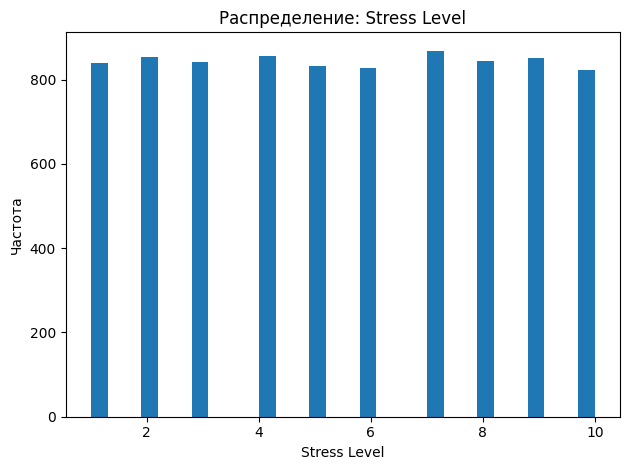

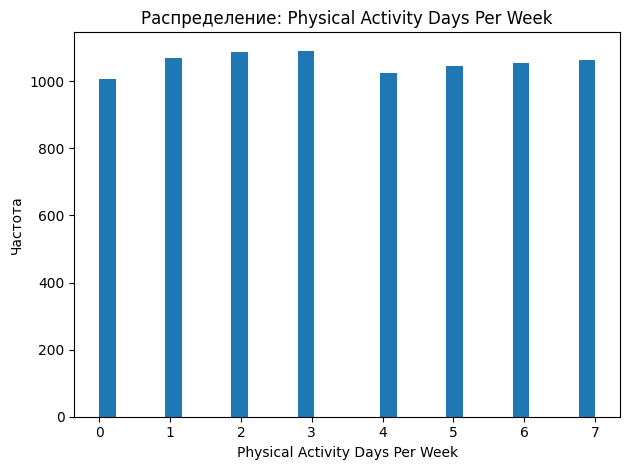

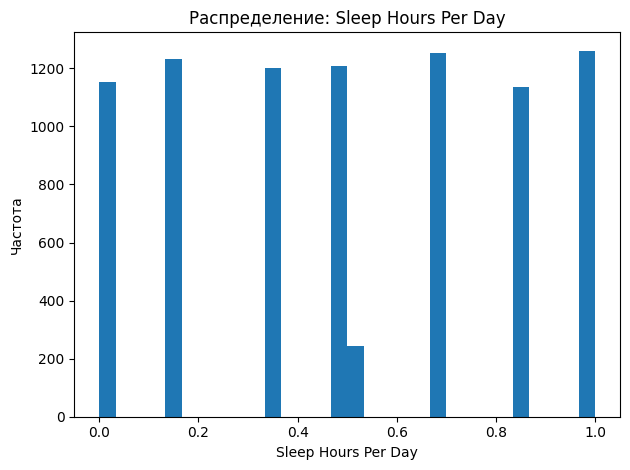

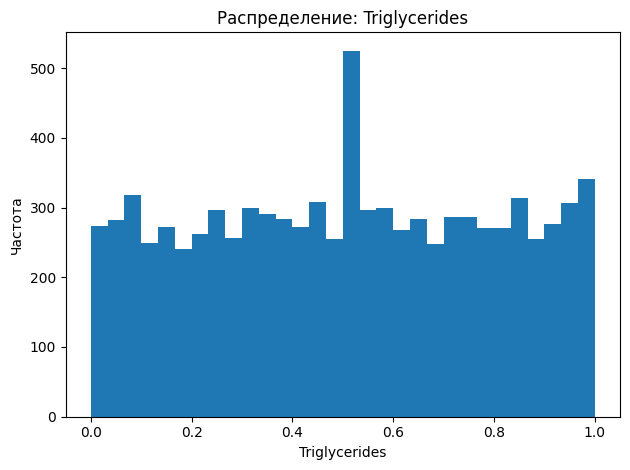

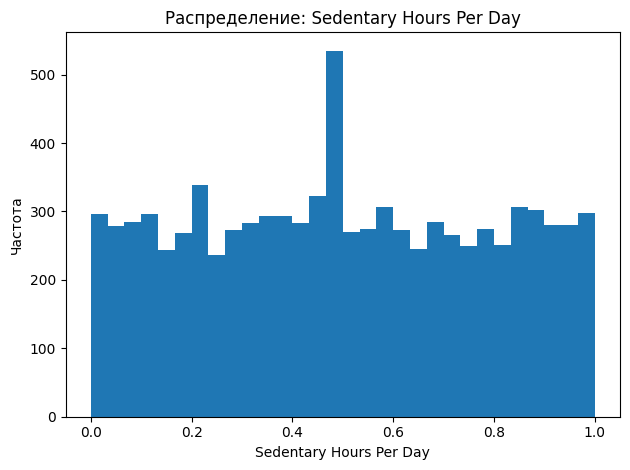

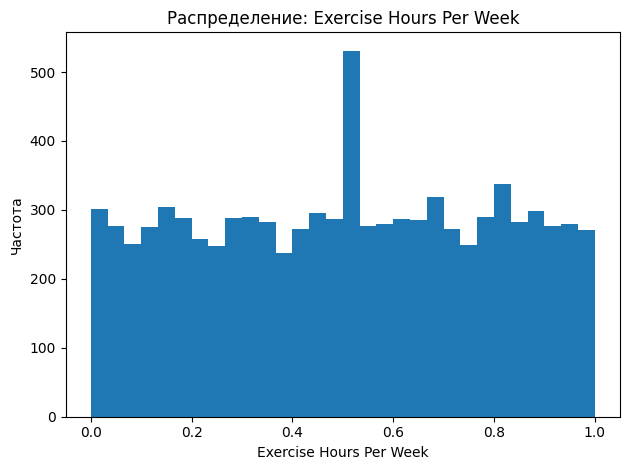

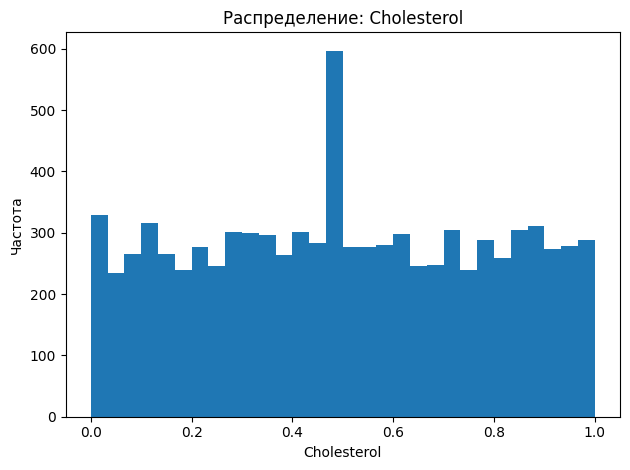

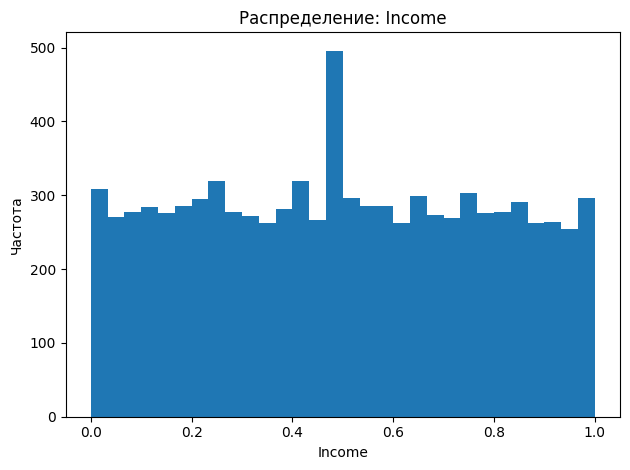

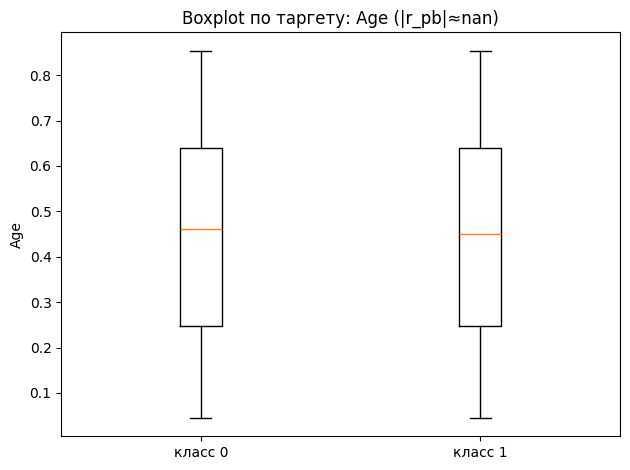

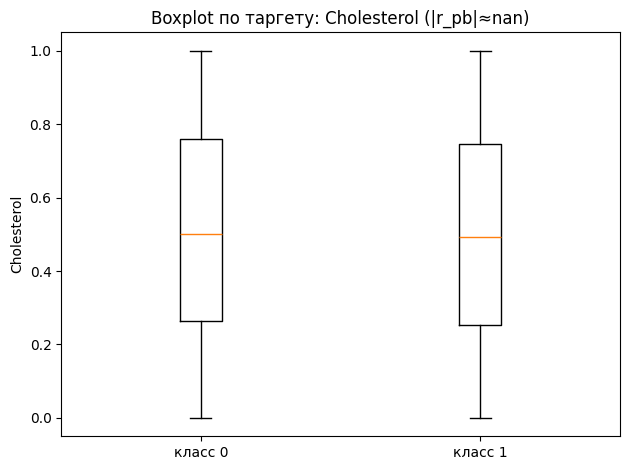

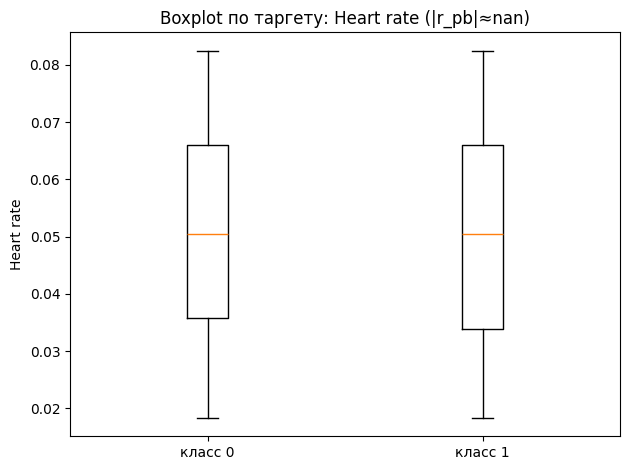

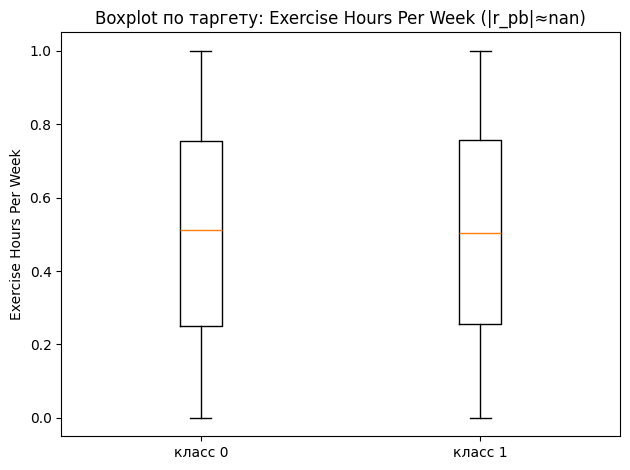

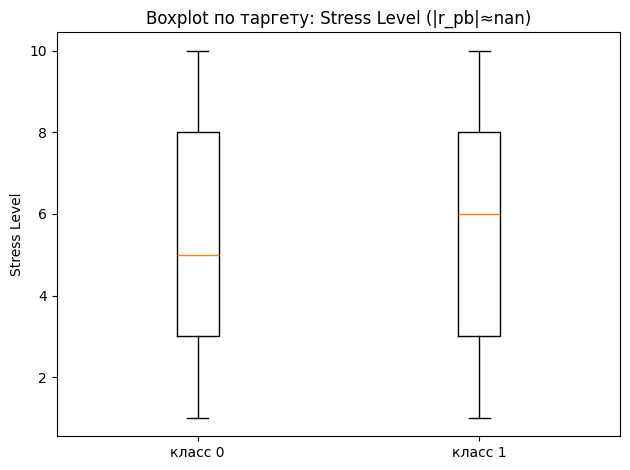

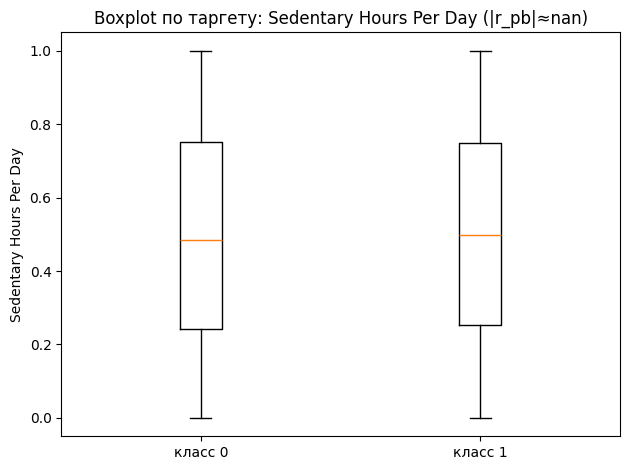

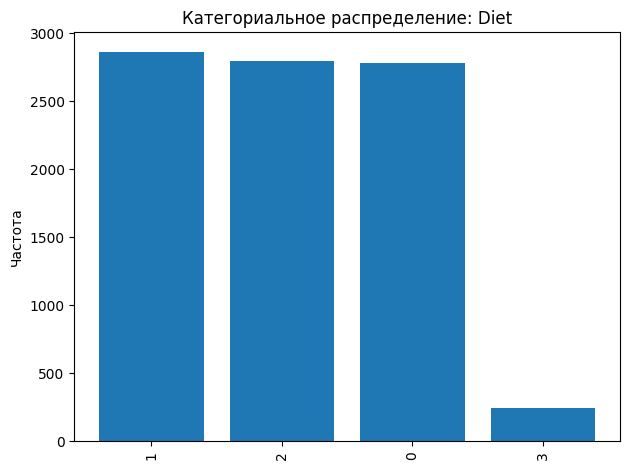

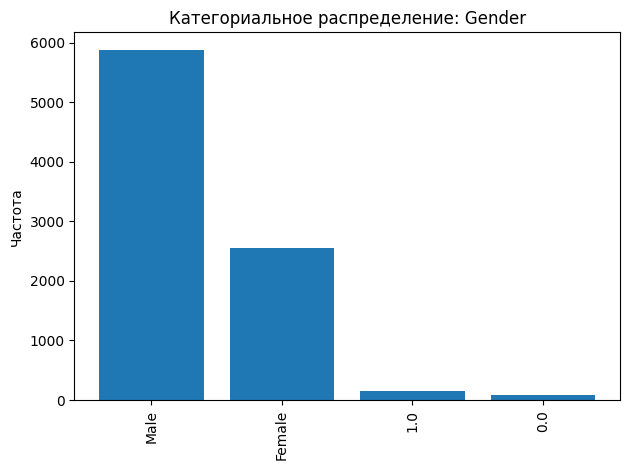

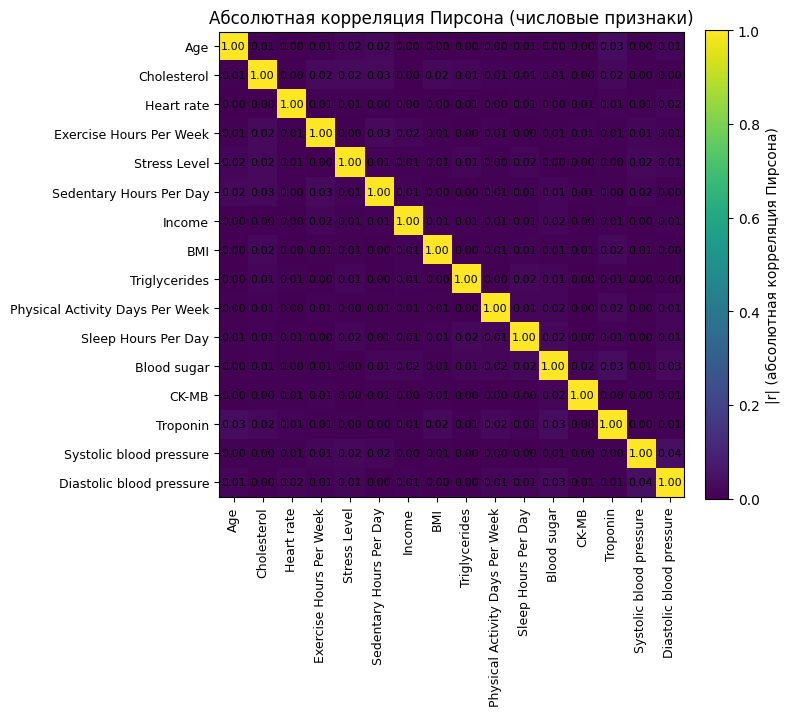

,Признак,Значение_пика,Доля,Частота,Метод,Комментарий,Возможная_импутация
0,Blood sugar,0.23,0.763961,6635,гистограмма,бин №11: 6635 наблюдений; соседние 94 и 67,False
1,CK-MB,0.05,0.762694,6624,гистограмма,бин №2: 6624 наблюдений; соседние 159 и 41,False
2,Troponin,0.03,0.762464,6622,гистограмма,бин №1: 6622 наблюдений; соседние 1708 и 58,False
3,Sleep Hours Per Day,1.00,0.145193,1261,точное_значение,частое точечное значение,False
4,Sleep Hours Per Day,0.67,0.144157,1252,гистограмма,бин №33: 1252 наблюдений; соседние 0 и 0,False
5,Sleep Hours Per Day,0.17,0.141739,1231,гистограмма,бин №8: 1231 наблюдений; соседние 0 и 0,False
6,Sleep Hours Per Day,0.50,0.139090,1208,точное_значение,частое точечное значение,True
7,Sleep Hours Per Day,0.49,0.139090,1208,гистограмма,бин №24: 1208 наблюдений; соседние 0 и 243,False
8,Sleep Hours Per Day,0.33,0.138169,1200,гистограмма,бин №16: 1200 наблюдений; соседние 0 и 0,False
9,Sleep Hours Per Day,0.00,0.132758,1153,точное_значение,частое точечное значение,False


In [178]:
data_dir = Path("..") / "data"
train_path = next(data_dir.glob("*heart_train*.csv"))
test_path  = next(data_dir.glob("*heart_test*.csv"))

eda = MedicalEDA(train_path=train_path, test_path=test_path).run_all(
    corr_threshold=0.9,
    vif_max_features=30,
    plots_numeric=8,
    plots_cat=6,
    plots_box=6,
)

# Посмотреть пики
eda.spikes_table.head(20)


## Отчёт по результатам EDA

### Числовые признаки
- **Age, Cholesterol, Heart rate, Exercise Hours Per Week, Sedentary Hours Per Day**
  - Распределения по классам (0 и 1) почти идентичны, медианы совпадают.
  - Значимых различий в форме распределений не наблюдается.
  - Выбросы присутствуют, но не выглядят аномальными — скорее отражают реальных крайних наблюдаемых значений.
- **Stress Level**
  - Лёгкий сдвиг медианы в сторону большего значения у класса 1.
  - Диапазон значений одинаковый для обоих классов.
  - Выбросов нет, но в некоторых признаках есть шипы, проверим влияние на модели

### Категориальные признаки
- **Diet**
  - Категории 0, 1, 2 встречаются примерно одинаково часто, категория 3 — редкая.
- **Gender**
  - Обнаружено смешение форматов: есть текстовые значения ("Male", "Female") и числовые (1.0, 0.0).
  - Это явная несогласованность кодирования, требующая очистки.

---

## Следующие шаги
1. **Числовые признаки**
   - Проверить корреляции с таргетом и между признаками, чтобы выявить мультиколлинеарность.
   - Оставить выбросы, если они отражают реальные данные; при необходимости — протестировать модели с и без их удаления.
2. **Категориальные признаки**
   - Привести `Gender` к единому формату (либо полностью строковому, либо числовому).
   - Рассмотреть перекодировку `Diet` с учётом того, что категория 3 малочисленная (возможна группировка или отдельная бинарная фича).
3. **Общее**
   - Проверить баланс классов по таргету.
   - Подготовить данные к one-hot/label encoding перед моделированием.
